### Importando librerias necesarias

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,TimeSeriesSplit
import matplotlib.pyplot as plt
from Crossvalidation import MultipleTimeSeriesCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,RocCurveDisplay,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from Backtesting import backtest_1day_hold,backtest_1day_hold_train_test,backtest_1day_hold_train_test_market,backtest_1day_hold_open
from Crossvalidation import MultipleTimeSeriesCV,plot_time_series_split,walk_forward_validation
import warnings
warnings.filterwarnings("ignore")

### Entrenamiento de Modelos

In [2]:
# Cargamos los datos originales
df = pd.read_csv('../spyconalfas.csv')

<AxesSubplot:>

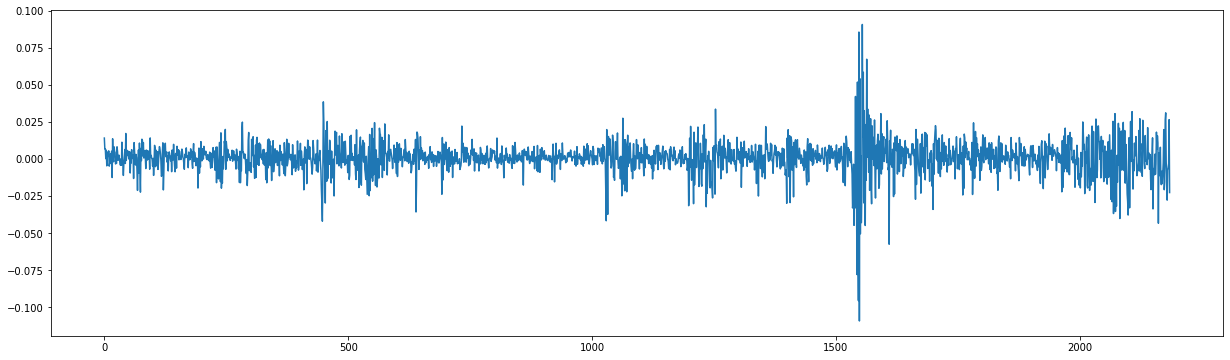

In [3]:
# Visualizamos los retornos
df['next returns'].plot(y='Date',figsize=(21,6))

In [4]:
# Separamos en X - (conjunto de entrenamiento) y Y - (etiquetas de los movimientos)
Y = df['next movement']
X = df
X.drop(['next movement','alpha53'],axis=1,inplace=True)

Tras haber separado las etquetas de los datos y haber eliminado Date y Alpha53, procedemos a separar en Train/Test:

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

fecha_inicio_train = X_train['Date'].iloc[0]
fecha_fin_train = X_train['Date'].iloc[-1]
fecha_inicio_test = X_test['Date'].iloc[0]
fecha_fin_test = X_test['Date'].iloc[-1]

print('Intervalo de entrenamiento:',fecha_inicio_train,'-',fecha_fin_train)
print('Intervalo de prueba:',fecha_inicio_test,'-',fecha_fin_test)

Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13

In [ ]:
import yfinance as yf

close_open = yf.Ticker('SPY')
from datetime import timedelta

close_open  = close_open .history(start=fecha_inicio_test,
                                    end=(pd.to_datetime(fecha_fin_test) + timedelta(1)).strftime('%Y-%m-%d'))
close_open  = close_open [['Open', 'Close']]
close_open  = close_open.iloc[1:, :]
close_open

Ahora tomamos los retornos, los necesitaremos para calcular el rendimiento de nuestro algoritmo:

In [ ]:
X_train_ret = X_train['next returns']
X_test_ret = X_test['next returns']

16 de abril?

In [ ]:
X_train.drop(['next returns','Date'],axis=1,inplace=True)
X_test.drop(['next returns','Date'],axis=1,inplace=True)

In [ ]:
#Plotear Train/Test
plt.figure(figsize=(21,6))
plt.plot(X_train_ret)
plt.plot(X_test_ret)

Añadimos el preprocesado necesario:

In [ ]:
X_train.describe()

In [ ]:
X_test

In [ ]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler  = StandardScaler()

X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [ ]:
X_train

In [ ]:
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True


param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.001,0.01,0.1,0.5,1],
    'max_iter' :[100,500,1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

#Gamma para todos menos lineal, degree solo para poly, C todos
param_svm = {
    'C' : [0.1,1,10],
    'kernel': ['linear','rbf','poly','sigmoid'],
    'gamma' :[0.01,0.1,1,1000]
}


param_rf = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.001,0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300,400],
    'gamma' : [0,1,5,10,20,30],
    'reg_alpha' : [0.001,0.01,0.1,1],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    for estimator,name in zip(list_estimators_entrenados,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_train)
        mat = ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Train.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_train,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Train.jpg'.format(name,metrica))
        plt.close(display.figure_)
        Y_pred = estimator.predict(X_test)
        mat = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Test.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_test,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Test.jpg'.format(name,metrica))
        plt.close(display.figure_)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

In [ ]:
###############################################################################
####################################PRUEBA#####################################
###############################################################################
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True

#   Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.01, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'shuffle': False}
# Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01],
    'max_iter' :[1000],
    'alpha' : [0.01,0.001],
    'shuffle': [False]
}

#Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
#Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
param_svm = {
    'C' : [0.1,10],
    'kernel': ['linear','rbf'],
    'gamma' :[0.1]
}

# Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
#Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
param_rf = {
    'n_estimators':[100,250],
    'max_depth' : [4,7],
    'criterion' : ['gini'],
    'random_state': [42]
}

# Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
# Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
param_xgb = {
    'max_depth' : [3],
    'learning_rate' : [0.01],
    'n_estimators' : [200,300],
    'gamma' : [10],
    'reg_alpha' : [0.01],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,verbose=1,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

In [ ]:
df_con_fechas = pd.read_csv('../spyconalfas.csv')
df_con_fechas

In [ ]:
df_con_fechas[cols_to_norm] = scaler.transform(df_con_fechas[cols_to_norm])
df_con_fechas

In [ ]:
import yfinance as yf
df_con_close = yf.Ticker('SPY')

In [ ]:
from datetime import timedelta


df_con_close=df_con_close.history(start=fecha_inicio_test,end=(pd.to_datetime(fecha_fin_test)+timedelta(1)).strftime('%Y-%m-%d'))

In [ ]:
df_con_close = df_con_close[['Open','Close']]

In [ ]:
df_con_close = df_con_close.iloc[1:,:]

In [ ]:
df_con_close

In [ ]:
primero = True

plt.figure(figsize=(20,10))
for estimator,name in zip(list_estimators_entrenados,list_names):
    Y_pred = estimator.predict(X_test)
    if primero:
        mercado=1
        primero=False
    else:
        mercado=0
    backtest_1day_hold_open(df_con_close['Open'],df_con_close['Close'],X_test_ret,Y_pred,verbose=0,show_market=mercado,label=name)
plt.title('Curva de Capital ({})'.format(metrica))
plt.legend()
plt.show()

In [10]:
X_train.describe()

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,...,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,226.318059,-0.000205,0.095224,0.228392,-0.653699,-0.248775,-0.554772,-0.496605,-0.138158,0.496278,...,-0.333725,0.000557,0.000582,0.000479,0.000472,0.000480,0.000518,0.000597,0.000581,0.000571
std,53.544227,0.276803,0.451406,0.384091,0.325972,0.135081,0.670345,0.274105,2.717071,0.274574,...,0.238254,0.010978,0.011021,0.011035,0.011045,0.011052,0.011056,0.011052,0.011028,0.011048
min,143.668335,-0.443642,-0.978837,-0.895961,-1.000000,-0.500199,-1.000000,-1.000000,-20.312088,0.000397,...,-0.994652,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424
25%,180.515022,-0.177497,-0.242479,-0.011643,-1.000000,-0.364030,-1.000000,-0.731115,-1.137115,0.262222,...,-0.503291,-0.003076,-0.003132,-0.003170,-0.003170,-0.003192,-0.003182,-0.003098,-0.003059,-0.003044
50%,220.392853,0.002006,0.115109,0.263202,-0.777778,-0.247407,-1.000000,-0.491607,-0.101288,0.495032,...,-0.290112,0.000597,0.000637,0.000552,0.000552,0.000588,0.000637,0.000637,0.000653,0.000643
75%,266.538589,0.302447,0.444271,0.539721,-0.333333,-0.134573,-0.166667,-0.262890,0.697960,0.729630,...,-0.132383,0.005182,0.005209,0.005142,0.005110,0.005161,0.005209,0.005325,0.005212,0.005227
max,364.738800,0.302447,0.972121,0.937606,-0.111111,-0.000199,1.000000,-0.002398,28.222427,1.000000,...,-0.000411,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603


In [11]:
X_test

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
1748,369.831207,0.302447,0.773566,-0.260968,-1.000000,-0.444156,-0.616667,-0.880895,-5.414337,0.037361,...,-0.196627,0.005979,-0.013614,0.001427,-0.001908,0.008591,0.003890,-0.003993,0.008618,-0.004427
1749,371.938385,0.302447,0.478898,-0.160313,-1.000000,-0.479656,-0.750000,-0.888489,-2.107178,0.876789,...,-0.380090,0.014858,0.006887,0.005081,0.001427,-0.001908,0.008591,-0.003575,-0.002055,0.010937
1750,369.431244,0.002006,0.571287,0.123307,-1.000000,-0.428400,-1.000000,-0.930855,2.507141,0.894674,...,-0.283838,0.005698,0.005979,-0.013614,0.005081,0.001427,-0.001908,-0.001685,0.002926,0.002104
1751,369.509216,-0.177497,-0.827823,0.323170,-0.777778,-0.438172,-1.000000,-0.796163,-0.077972,0.483704,...,-0.444268,-0.006741,0.014858,0.006887,-0.013614,0.005081,0.001427,0.000899,-0.008969,-0.000272
1752,370.504333,-0.320899,-0.865147,0.430441,-1.000000,-0.405265,-1.000000,-0.714628,-0.995117,0.271463,...,-0.058121,0.000211,0.005698,0.005979,0.006887,-0.013614,0.005081,0.003890,-0.000327,0.008618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,362.790009,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,-0.986411,10.410004,0.990859,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2181,360.019989,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,-0.967626,2.770020,0.106518,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2182,357.739990,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,-0.566347,-2.279999,0.133943,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544
2183,356.559998,-0.320899,0.091750,0.020725,-0.222222,-0.024332,-1.000000,-0.050759,-1.179993,0.247615,...,-0.247223,-0.006333,-0.027894,-0.002328,0.030987,0.026401,-0.015464,-0.009893,0.010748,-0.003773


In [12]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler  = StandardScaler()

X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [13]:
X_train

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
0,-1.544020,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049835,0.774245,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
1,-1.506536,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006516,0.157393,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2,-1.488348,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973587,0.275437,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
3,-1.469844,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990494,0.272655,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
4,-1.469685,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008469,0.507552,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,2.551462,-0.177497,0.434895,0.205681,-1.000000,-0.395891,-1.000000,-0.823741,-0.517090,0.370429,...,-0.203209,-0.001908,0.003890,-0.001685,-0.003575,-0.003993,0.005592,-0.001173,0.002785,-0.006848
1744,2.585906,0.302447,0.134440,0.153597,-0.888889,-0.326286,-0.483333,-0.733014,-1.843750,0.176868,...,-0.112299,0.001427,0.008591,0.000899,-0.001685,-0.003575,-0.003993,-0.004477,-0.004427,0.005994
1745,2.493142,0.002006,0.553204,-0.080359,-0.222222,-0.465496,-0.150000,-0.156675,4.965546,0.959459,...,-0.045660,0.005081,-0.001908,0.003890,0.000899,-0.001685,-0.003575,0.013519,0.010937,0.016114
1746,2.539433,-0.177497,0.663167,-0.024306,-0.555556,-0.082170,-0.366667,-0.171863,-2.477875,0.120032,...,-0.053065,-0.013614,0.001427,0.008591,0.003890,0.000899,-0.001685,0.001569,0.002104,-0.001542


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 20}
Win rate: (Regresión Logística) 0.502283105022831
Win rate: (SVM) 0.5136986301369864
Win rate: (RandomForest) 0.5068493150684932
Win rate: (XGBoost) 0.5136986301369864


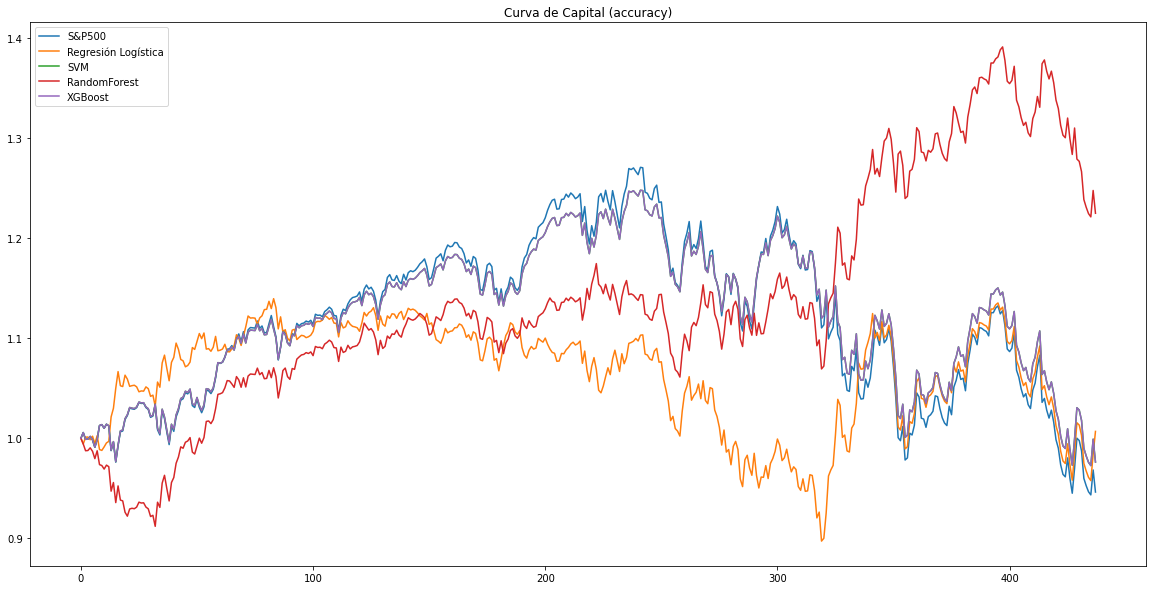

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.1, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 0}
Win rate: (Regresión Logística) 0.502283105022831
Win rate: (SVM) 0.5251141552511416
Win rate: (RandomForest) 0.4977168949771689
Win rate: (XGBoost) 0.5068493150684932


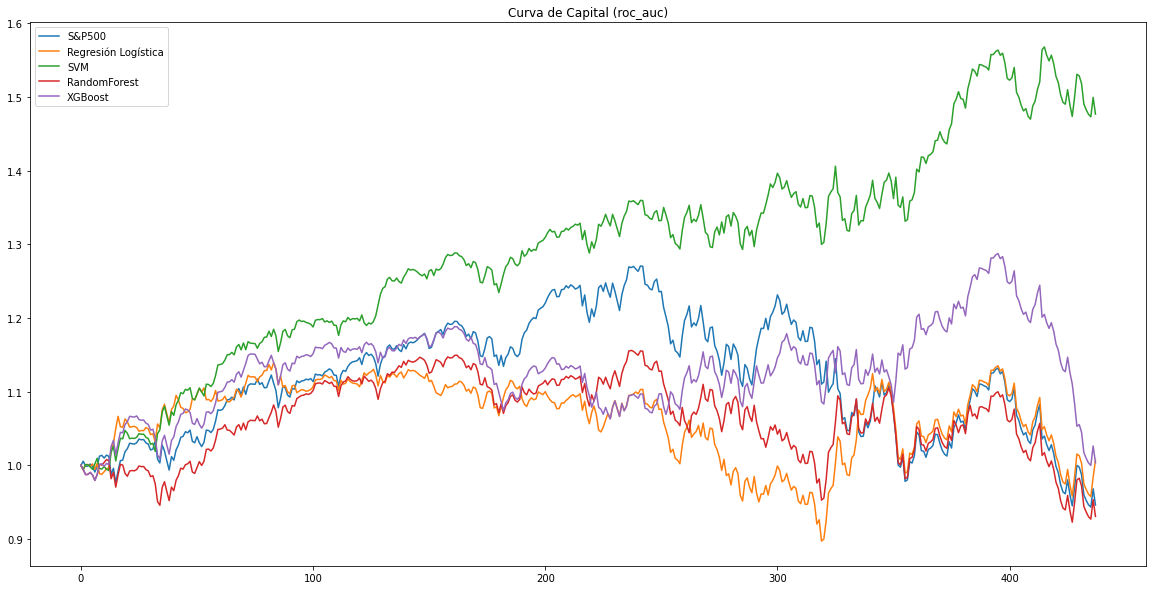

In [14]:
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True


param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.001,0.01,0.1,0.5,1],
    'max_iter' :[100,500,1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

#Gamma para todos menos lineal, degree solo para poly, C todos
param_svm = {
    'C' : [0.1,1,10],
    'kernel': ['linear','rbf','poly','sigmoid'],
    'gamma' :[0.01,0.1,1,1000]
}


param_rf = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.001,0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300,400],
    'gamma' : [0,1,5,10,20,30],
    'reg_alpha' : [0.001,0.01,0.1,1],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    for estimator,name in zip(list_estimators_entrenados,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_train)
        mat = ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Train.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_train,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Train.jpg'.format(name,metrica))
        plt.close(display.figure_)
        Y_pred = estimator.predict(X_test)
        mat = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Test.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_test,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Test.jpg'.format(name,metrica))
        plt.close(display.figure_)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Day  1 Going Short : Amount betted: 1 Daily return: 0.0056976742171082  End amount: 0.9943023257828918 Equity change: -0.005697674217108206 Equity: 0.9943023257828918
Day  2 Going long : Amount betted: 1 Daily return: -0.00674074312931  End amount: 0.99325925687069 Equity change: -0.006740743129309945 Equity: 0.9875615826535818
Day  3 Going long : Amount betted: 1 Daily return: 0.0002110606869276  End amount: 1.0002110606869277 Equity change: 0.00021106068692766655 Equity: 0.9877726433405095
Day  4 Going long : Amount betted: 1 Daily return: 0.0026930781251988  End amount: 1.0026930781251988 Equity change: 0.002693078125198811 Equity: 0.9904657214657083
Day  5 Going long : Amount betted: 1 Daily return: -0.0035019437946093  End amount: 0.996498056205

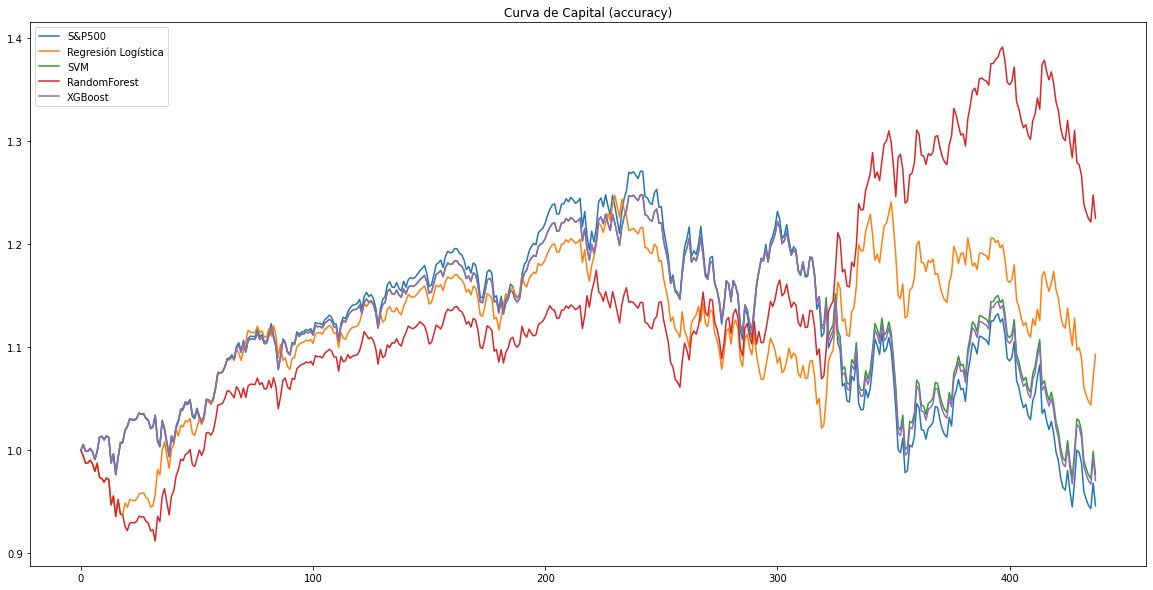

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Day  1 Going Short : Amount betted: 1 Daily return: 0.0056976742171082  End amount: 0.9943023257828918 Equity change: -0.005697674217108206 Equity: 0.9943023257828918
Day  2 Going Short : Amount betted: 1 Daily return: -0.00674074312931  End amount: 1.00674074312931 Equity change: 0.006740743129310056 Equity: 1.0010430689122018
Day  3 Going long : Amount betted: 1 Daily return: 0.0002110606869276  End amount: 1.0002110606869277 Equity change: 0.00021106068692766655 Equity: 1.0012541295991295
Day  4 Going Short : Amount betted: 1 Daily return: 0.0026930781251988  End amount: 0.9973069218748012 Equity change: -0.002693078125198811 Equity: 0.9985610514739307
Day  5 Going Short : Amount betted: 1 Daily return: -0.0035019437946093  End amount: 1.003501943

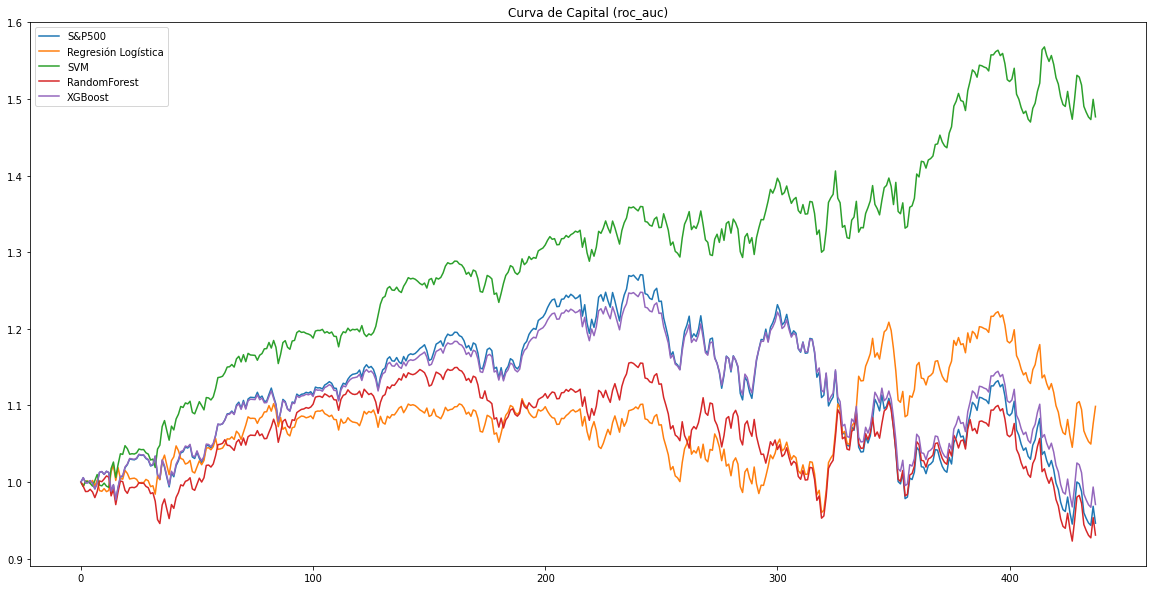

In [15]:
###############################################################################
####################################PRUEBA#####################################
###############################################################################
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True

#   Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.01, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'shuffle': False}
# Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01],
    'max_iter' :[1000],
    'alpha' : [0.01,0.001],
    'shuffle': [False]
}

#Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
#Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
param_svm = {
    'C' : [0.1,10],
    'kernel': ['linear','rbf'],
    'gamma' :[0.1]
}

# Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
#Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
param_rf = {
    'n_estimators':[100,250],
    'max_depth' : [4,7],
    'criterion' : ['gini'],
    'random_state': [42]
}

# Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
# Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
param_xgb = {
    'max_depth' : [3],
    'learning_rate' : [0.01],
    'n_estimators' : [200,300],
    'gamma' : [10],
    'reg_alpha' : [0.01],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,verbose=1,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

In [16]:
df_con_fechas = pd.read_csv('../spyconalfas.csv')
df_con_fechas

,Date,next movement,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
0,2013-10-15,1,0.013966,143.668335,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
1,2013-10-16,1,0.006683,145.674850,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2,2013-10-17,1,0.006754,146.648438,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
3,2013-10-18,1,0.000057,147.638931,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
4,2013-10-21,1,0.005791,147.647400,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,2022-10-07,0,-0.007635,362.790009,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2181,2022-10-10,0,-0.006333,360.019989,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2182,2022-10-11,0,-0.003298,357.739990,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544
2183,2022-10-12,1,0.026391,356.559998,-0.320899,0.091750,0.020725,-0.222222,-0.024332,-1.000000,...,-0.247223,-0.006333,-0.027894,-0.002328,0.030987,0.026401,-0.015464,-0.009893,0.010748,-0.003773


In [17]:
df_con_fechas[cols_to_norm] = scaler.transform(df_con_fechas[cols_to_norm])
df_con_fechas

,Date,next movement,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
0,2013-10-15,1,0.013966,-1.544020,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
1,2013-10-16,1,0.006683,-1.506536,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2,2013-10-17,1,0.006754,-1.488348,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
3,2013-10-18,1,0.000057,-1.469844,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
4,2013-10-21,1,0.005791,-1.469685,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,2022-10-07,0,-0.007635,2.549500,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2181,2022-10-10,0,-0.006333,2.497752,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2182,2022-10-11,0,-0.003298,2.455158,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544
2183,2022-10-12,1,0.026391,2.433114,-0.320899,0.091750,0.020725,-0.222222,-0.024332,-1.000000,...,-0.247223,-0.006333,-0.027894,-0.002328,0.030987,0.026401,-0.015464,-0.009893,0.010748,-0.003773


In [18]:
import yfinance as yf
df_con_close = yf.Ticker('SPY')

In [19]:
from datetime import timedelta


df_con_close=df_con_close.history(start=fecha_inicio_test,end=(pd.to_datetime(fecha_fin_test)+timedelta(1)).strftime('%Y-%m-%d'))

In [20]:
df_con_close = df_con_close[['Open','Close']]

In [21]:
df_con_close = df_con_close.iloc[1:,:]

In [22]:
df_con_close

,Open,Close
Date,,
2021-01-07,366.904556,369.831207
2021-01-08,371.284753,371.938385
2021-01-11,368.611785,369.431244
2021-01-12,369.626338,369.509247
2021-01-13,369.431222,370.504333
...,...,...
2022-10-07,368.970001,362.790009
2022-10-10,363.959991,360.019989
2022-10-11,358.239990,357.739990


Win rate: (Regresión Logística) 0.5342465753424658
Win rate: (SVM) 0.5365296803652968
Win rate: (RandomForest) 0.5365296803652968
Win rate: (XGBoost) 0.5365296803652968


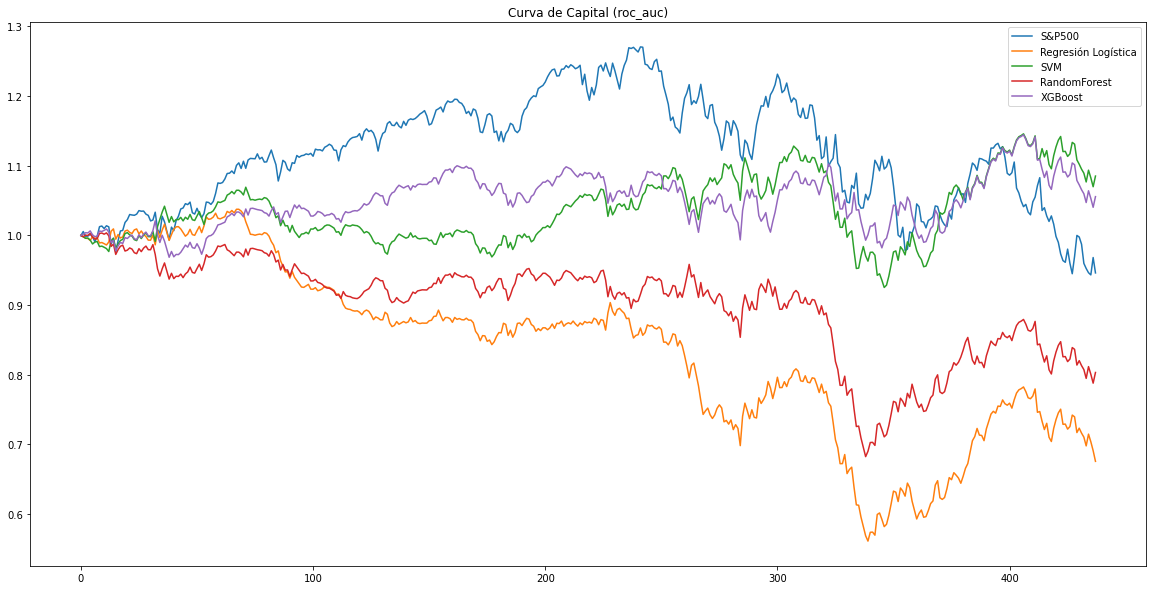

In [23]:
primero = True

plt.figure(figsize=(20,10))
for estimator,name in zip(list_estimators_entrenados,list_names):
    Y_pred = estimator.predict(X_test)
    if primero:
        mercado=1
        primero=False
    else:
        mercado=0
    backtest_1day_hold_open(df_con_close['Open'],df_con_close['Close'],X_test_ret,Y_pred,verbose=0,show_market=mercado,label=name)
plt.title('Curva de Capital ({})'.format(metrica))
plt.legend()
plt.show()